# Perlin Maps

The aim of this notebook is to produce standard Perlin maps that can be used by BattleSimulator as the background for height maps. These will be saved as a .png.

We use just in-time compiling (JIT) to significantly speed up image generation.

In [180]:
import numpy as np
import math
import sys
from numba import jit

import matplotlib.pyplot as plt

In [260]:
@jit
def fade(t):
    return t*t*t * (t * (t * 6 - 15) + 10)


@jit
def lerp(t, a, b):
    return a + t * (b - a)


@jit
def grad(h, x, y, z):
    h1 = np.bitwise_and(h,15)
    u = x if (h1 < 8) else y
    v = y if (h1 < 4) else x if ((h1==12) or (h1==14)) else z
    return (u if (np.bitwise_and(h1,1) == 0) else -u) + (v if (np.bitwise_and(h1,2) == 0) else -v)


@jit
def perlin_noise(p, x, y, z):
    X = np.bitwise_and(int(np.floor(x)), 255)
    Y = np.bitwise_and(int(np.floor(y)), 255)
    Z = np.bitwise_and(int(np.floor(z)), 255)
    
    x -= int(x)
    y -= int(y)
    z -= int(z)
    
    u = fade(x)
    v = fade(y)
    
    A = p[X]+Y
    
    AA = p[A]+Z
    AB = p[A+1]+Z
    B = p[X+1]+Y
    BA = p[B] + Z
    BB = p[B+1] + Z
    
    # print(x, y, z, X, Y, Z, u, v, A, AA, AB, B, BA,BB)
    
    V1 = lerp(v, lerp(u, grad(p[AA], x, y, z),
                        grad(p[BA], x-1, y, z)),
                        lerp(u, grad(p[AB], x, y-1, z),
                            grad(p[BB], x-1, y-1, z)))
    V2 = lerp(v, lerp(u, grad(p[AA+1],x,y,z-1),
                        grad(p[BA+1],x-1,y,z-1)),
                        lerp(u, grad(p[AB+1], x, y-1, z-1),
                            grad(p[BB+1], x-1, y-1, z-1)))
    return (V1 + V2) / 2.


@jit
def minmax(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [310]:
@jit(nopython=True)
def perlin_image(pm, w, h, scale, seed, octaves=1, persist=.5, lacunarity=2):
    """Returns an ndarray for the height map"""
    image = np.empty(w*h, dtype=np.float64)
    
    if (seed == -1):
        xoff = np.random.randint(0,100000)
        yoff = np.random.randint(0,100000)
    else:
        xoff = seed
        yoff = seed

    pmax = -sys.maxsize
    pmin = sys.maxsize
    hW = w/2.
    hH = h/2.
    
    for y in range(h):
        for x in range(w):
            amp = 1.
            freq = 1.
            noiseH = 0.0
            
            for i in range(octaves):
                sx = (((x-hW) / w) * scale * freq) + xoff
                sy = (((y-hH) / h) * scale * freq) + yoff
                p = perlin_noise(pm, sx, sy, .8)
                
                # print(sx, sy, p)
                
                noiseH += p * amp
                amp *= persist
                freq *= lacunarity
            
            if (noiseH < pmin):
                pmin = noiseH
            if (noiseH > pmax):
                pmax = noiseH
            
            image[y*w + x] = noiseH
    
    return minmax(image)

In [311]:
p = np.zeros(512, dtype=int)
permutation = np.array([
    151,160,137,91,90,15,
    131,13,201,95,96,53,194,233,7,225,140,36,103,30,69,142,8,99,37,240,21,10,23,
    190, 6,148,247,120,234,75,0,26,197,62,94,252,219,203,117,35,11,32,57,177,33,
    88,237,149,56,87,174,20,125,136,171,168, 68,175,74,165,71,134,139,48,27,166,
    77,146,158,231,83,111,229,122,60,211,133,230,220,105,92,41,55,46,245,40,244,
    102,143,54, 65,25,63,161, 1,216,80,73,209,76,132,187,208, 89,18,169,200,196,
    135,130,116,188,159,86,164,100,109,198,173,186, 3,64,52,217,226,250,124,123,
    5,202,38,147,118,126,255,82,85,212,207,206,59,227,47,16,58,17,182,189,28,42,
    223,183,170,213,119,248,152, 2,44,154,163, 70,221,153,101,155,167, 43,172,9,
    129,22,39,253, 19,98,108,110,79,113,224,232,178,185, 112,104,218,246,97,228,
    251,34,242,193,238,210,144,12,191,179,162,241, 81,51,145,235,249,14,239,107,
    49,192,214, 31,181,199,106,157,184, 84,204,176,115,121,50,45,127, 4,150,254,
    138,236,205,93,222,114,67,29,24,72,243,141,128,195,78,66,215,61,156,180
], dtype=np.int)
p[:256] = permutation
p[256:] = permutation

In [316]:
X.shape

(360000,)

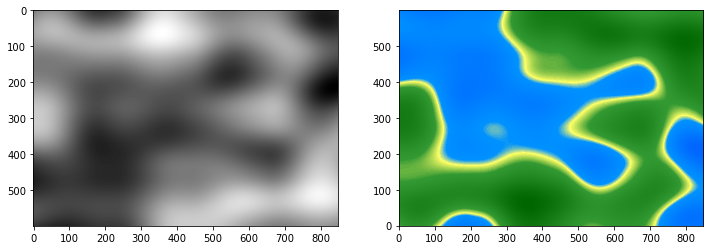

In [365]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

X = perlin_image(p, 847, 600, 4, seed=123456)
ax[0].imshow(X.reshape(600, 847), cmap="gray", aspect=True)

grassland = (np.array([[0, 102, 255], [0, 146, 255], [255, 255, 102], [51, 153, 51], [0, 102, 0]]) /255.) # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
nodes = np.array([0., .35, .4, .5, 1.])
cm = LinearSegmentedColormap.from_list("default", list(zip(nodes, grassland)))
ax[1].imshow(X.reshape(600,847), origin='lower', cmap=cm)